# построение диаграммы Герцшпрунг-Рассела с использованием предугаданных значений
------
выполнила : ученица 8'А' класса МАОУ Лицея №176 Чумасова Полина Юрьевна (aponiaauy@gmail.com)
    
научный руководитель : Бондарчук Глеб Сергеевич (djgleban1147@mail.ru)

для астрономов диаграмма Герцшпрунг-Рассела несет в себе много полезной информаци - цвет, спектральный класс, температура, размер, освещенность звезды, и даже возраст. Я решила создать программу для построения диаграммы, но используя предугаданные значения, чтобы решить возможную проблему нехватки расчетных данных, заодно экспериментальным путем найти лучшую ML-модель для нахождения данных 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import math
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KDTree
from catboost import CatBoostRegressor
import tqdm

import warnings
warnings.filterwarnings("ignore")

stefconst = 5.67 * 10**-8
pi = 3.14
Rro = 2.26*10**-8

df = pd.read_csv(r"6 class csv.csv")
df2 = pd.read_csv(r"paralaxo.csv")
df.drop(["Star color", "Spectral Class"], axis=1, inplace=True)
df2.drop(['SpType'],axis = 1, inplace=True)

df = df[df['Absolute magnitude(Mv)'] > 0]

In [5]:
tree = KDTree(df["Absolute magnitude(Mv)"].values.reshape((-1, 1)), leaf_size=3)
dist, ind = tree.query(df2["Amag"].values.reshape((-1, 1)), k=3)
mean_features = [df.iloc[idxes].mean(axis=0) for idxes in ind]
mean_features
df = pd.DataFrame(mean_features)
df.drop(['Star type'], axis = 1,inplace = True)
dfm  = pd.concat([df2,df],axis = 1)

In [6]:
m = np.array(dfm['Vmag'])
M = np.array(dfm['Amag'])
r = np.array(dfm['Radius(R/Ro)'])
t =  np.array(dfm['Temperature (K)'])

distance1 = 10 * 10**((m - M)/5)
distance1

F = 10**(-0.4*(m-M))
distance2 = ((r**2 * stefconst * t**4)/F)**0.5
distance1 = Rro * distance1
dfm["dist1"] = distance1
dfm["dist2"] = distance2
dfm

,Vmag,Plx,e_Plx,B-V,Amag,TargetClass,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),dist1,dist2
0,6.901420,24.569658,0.862829,0.737416,20.449126,1,2896.000000,0.000536,0.103533,20.006667,4.411305e-10,0.403578
1,4.334196,2.198947,0.593309,1.153210,13.043324,0,6683.000000,0.004227,0.196307,13.053333,4.095273e-09,37.830661
2,7.873019,11.750465,0.616568,0.589166,17.736492,1,3012.333333,0.000465,0.118333,17.486667,2.406655e-09,2.722765
3,8.110014,2.143815,0.848508,1.322107,15.592469,0,2917.000000,0.000940,0.131333,16.086667,7.204725e-09,8.482978
4,8.025193,4.165622,0.899296,1.141646,16.379680,0,3227.000000,0.002512,0.092367,16.343333,4.821819e-09,4.886605
...,...,...,...,...,...,...,...,...,...,...,...,...
31636,7.561113,0.692340,0.843319,0.252874,12.542120,0,10837.666667,0.002177,0.115000,12.490000,2.279854e-08,324.458854
31637,8.078011,3.002784,0.689891,0.971966,15.379710,0,6714.333333,0.000557,0.117857,14.873333,7.830125e-09,43.834061
31638,7.065964,7.820498,0.885794,0.435381,16.737442,1,3048.333333,0.000314,0.116567,16.676667,2.629136e-09,3.000512
31639,8.685452,2.643033,1.064647,0.988600,14.859882,0,6482.000000,0.000740,0.059190,14.823333,1.315899e-08,34.480375


In [7]:
corr = abs(dfm.corr())
corr.style.background_gradient(cmap='coolwarm')

,Vmag,Plx,e_Plx,B-V,Amag,TargetClass,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),dist1,dist2
Vmag,1.000000,0.191414,0.557063,0.046950,0.287126,0.128945,0.196061,0.026745,0.112961,0.284049,0.128052,0.045755
Plx,0.191414,1.000000,0.062239,0.074046,0.635550,0.348977,0.354138,0.085998,0.225950,0.604719,0.263955,0.156909
e_Plx,0.557063,0.062239,1.000000,0.053166,0.260421,0.102710,0.150619,0.020523,0.091803,0.248797,0.055983,0.018725
B-V,0.046950,0.074046,0.053166,1.000000,0.073903,0.554469,0.078831,0.010179,0.043722,0.089820,0.052674,0.036435
Amag,0.287126,0.635550,0.260421,0.073903,1.000000,0.442479,0.664059,0.271669,0.433444,0.985104,0.523672,0.412249
TargetClass,0.128945,0.348977,0.102710,0.554469,0.442479,1.000000,0.280207,0.067565,0.184470,0.444541,0.154972,0.106062
Temperature (K),0.196061,0.354138,0.150619,0.078831,0.664059,0.280207,1.000000,0.059151,0.014395,0.696837,0.330377,0.307071
Luminosity(L/Lo),0.026745,0.085998,0.020523,0.010179,0.271669,0.067565,0.059151,1.000000,0.418548,0.302322,0.679467,0.621961
Radius(R/Ro),0.112961,0.225950,0.091803,0.043722,0.433444,0.184470,0.014395,0.418548,1.000000,0.448377,0.415716,0.343176
Absolute magnitude(Mv),0.284049,0.604719,0.248797,0.089820,0.985104,0.444541,0.696837,0.302322,0.448377,1.000000,0.540248,0.419883


In [8]:
dfm = dfm.drop(['Absolute magnitude(Mv)'], axis = 1)

In [9]:
y_co = ["Luminosity(L/Lo)"]
y_cols = ["Temperature (K)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_co, axis=1), dfm[y_co], test_size=0.2, random_state=42)

In [10]:
est = GradientBoostingRegressor(
        n_estimators=100, learning_rate=1.3, max_depth=1, random_state=0,
        loss='squared_error').fit(X_train, y_train)

boostin_without_log =  [est.predict(X_test), est.score(X_test, y_test).round(3)]
print("точность :",boostin_without_log[1])

точность : 0.999


In [11]:
esta = GradientBoostingRegressor()
log_rf = TransformedTargetRegressor(esta, func = np.log, inverse_func=np.exp)
log_rf.fit(X_train, y_train)
boostin_with_log = [log_rf.predict(X_test), log_rf.score(X_test, y_test).round(4)]
print("точность :", boostin_with_log[1])

точность : 0.989


### 2. K-ближайших соседей

In [12]:
regressor = KNeighborsRegressor(n_neighbors=3)
regressor = regressor.fit(X_train, y_train)

nearest_without_log = [regressor.predict(X_test),regressor.score(X_test, y_test).round(3)]
print("точность :",nearest_without_log[1])

точность : 0.991


In [13]:
regressor = KNeighborsRegressor(n_neighbors=3)
log = TransformedTargetRegressor(regressor, func = np.log, inverse_func=np.exp).fit(X_train, y_train)
log = log.fit(X_train, y_train)

nearest_with_log = [log.predict(X_test),log.score(X_test, y_test).round(3)]
print("точность :", nearest_with_log[1])

точность : 0.991


### 3. Дерево решений

In [14]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)

decisionTree_without_log = [clf.predict(X_test), clf.score(X_test, y_test).round(3)]
print("точность модели после :", decisionTree_without_log[1])

точность модели после : 1.0


In [15]:
clf = DecisionTreeRegressor()
log = TransformedTargetRegressor(clf, func = np.log, inverse_func = np.exp).fit(X_train, y_train)
log.predict(X_test)

decisionTree_with_log = [log.predict(X_test), log.score(X_test,y_test).round(3)]
print("точность модели после :", decisionTree_with_log[1])
#хочу ето

точность модели после : 1.0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_cols, axis=1), dfm[y_cols], test_size=0.2)

In [17]:
est = GradientBoostingRegressor(
 n_estimators=100, learning_rate=1.3, max_depth=1, random_state=0,
 loss='squared_error').fit(X_train, y_train)

pretemperature = est.predict(X_test)
print("точность модели до :",est.score(X_test, y_test).round(3))

точность модели до : 0.982


In [18]:
dfm

,Vmag,Plx,e_Plx,B-V,Amag,TargetClass,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),dist1,dist2
0,6.901420,24.569658,0.862829,0.737416,20.449126,1,2896.000000,0.000536,0.103533,4.411305e-10,0.403578
1,4.334196,2.198947,0.593309,1.153210,13.043324,0,6683.000000,0.004227,0.196307,4.095273e-09,37.830661
2,7.873019,11.750465,0.616568,0.589166,17.736492,1,3012.333333,0.000465,0.118333,2.406655e-09,2.722765
3,8.110014,2.143815,0.848508,1.322107,15.592469,0,2917.000000,0.000940,0.131333,7.204725e-09,8.482978
4,8.025193,4.165622,0.899296,1.141646,16.379680,0,3227.000000,0.002512,0.092367,4.821819e-09,4.886605
...,...,...,...,...,...,...,...,...,...,...,...
31636,7.561113,0.692340,0.843319,0.252874,12.542120,0,10837.666667,0.002177,0.115000,2.279854e-08,324.458854
31637,8.078011,3.002784,0.689891,0.971966,15.379710,0,6714.333333,0.000557,0.117857,7.830125e-09,43.834061
31638,7.065964,7.820498,0.885794,0.435381,16.737442,1,3048.333333,0.000314,0.116567,2.629136e-09,3.000512
31639,8.685452,2.643033,1.064647,0.988600,14.859882,0,6482.000000,0.000740,0.059190,1.315899e-08,34.480375


In [19]:
y_c = ['dist2']
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_c, axis=1), dfm[y_c], test_size=0.2,random_state=42)

In [20]:
model = CatBoostRegressor(loss_function='RMSE')
model.fit(X_train, y_train,verbose = 100)

Learning rate set to 0.068219
0:	learn: 577.9444486	total: 151ms	remaining: 2m 30s
100:	learn: 75.6155227	total: 668ms	remaining: 5.94s
200:	learn: 46.9099267	total: 1.14s	remaining: 4.54s
300:	learn: 34.4244389	total: 1.56s	remaining: 3.63s
400:	learn: 27.2736038	total: 1.98s	remaining: 2.96s
500:	learn: 23.3761070	total: 2.42s	remaining: 2.42s
600:	learn: 20.5020877	total: 2.83s	remaining: 1.88s
700:	learn: 17.9235006	total: 3.25s	remaining: 1.38s
800:	learn: 15.5573332	total: 3.65s	remaining: 907ms
900:	learn: 13.5370179	total: 4.07s	remaining: 448ms
999:	learn: 12.1161424	total: 4.47s	remaining: 0us


In [21]:
print((model.score(X_test,y_test)).round(3))

0.98


In [22]:
l = dfm['Luminosity(L/Lo)']
t = dfm['Temperature (K)']
r = dfm['Radius(R/Ro)']
t = t.round(1)
d = model.predict(X_test)
everycolor = []
for j in range(len(t)):
    if t[j] <= 4500 :
        everycolor.append(("#ff0000"))
    if t[j] >= 4501 and t[j] <= 6000:
        everycolor.append(("#ffa500"))
    if t[j] >= 6001 and t[j] <= 10000:
        everycolor.append(("#ffff00"))
    if t[j] >= 10001 and t[j] <= 15000:
        everycolor.append(("#ffffff"))
    if t[j] >= 15001:
        everycolor.append(("#0000ff"))

In [23]:
n = 3000

onlynlum = l[:n]
onlynlum = list(onlynlum)

maxonl = max(onlynlum)
sillyIndex = onlynlum.index(maxonl)
print(sillyIndex)

248


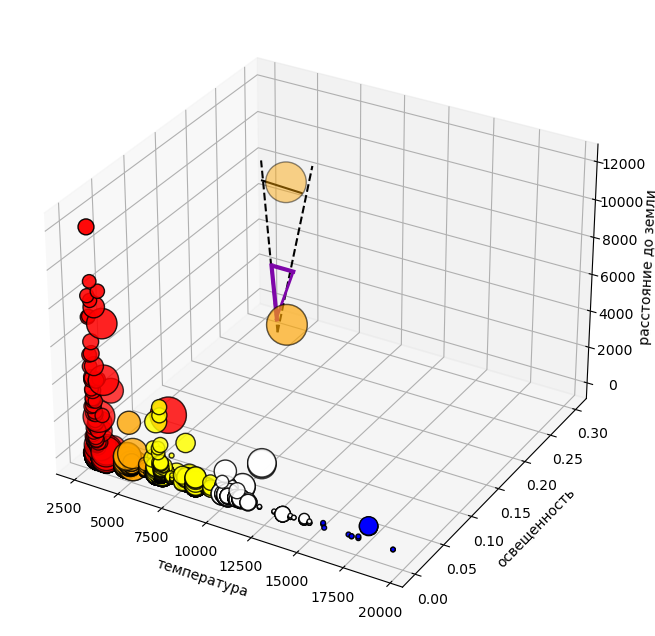

In [34]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

x = t[:n]
y = l[:n]
z = d[:n]
z[248] = 8000
Ra = r[sillyIndex]

X = t[sillyIndex]
Y = l[sillyIndex]
Z = d[sillyIndex]
ax.scatter(x,y,z,sizes = r[:n], c=everycolor[:n], marker = 'o',edgecolor = 'black', s = 100)

ax.set_xlabel("температура")
ax.set_ylabel("освещенность")
ax.set_zlabel("расстояние до земли")

ax.plot([4100,6500], [0.25,0.247],[8600], c = 'black')
ax.plot([4600, 4400], [0.26, 0.24], [0, 10000], c = 'black', linestyle='--')
ax.plot([4600, 5400], [0.26, 0.3], [0, 8500], c = 'black', linestyle='--')
ax.plot([3800, 4900], [0.28, 0.28], [3000, 3000], c = '#7E07A9',linewidth= 3)
ax.plot([3600, 3900], [0.28, 0.28], [3000, 0], c = '#7E07A9',linewidth= 3)
ax.plot([4900, 3850], [0.28, 0.28], [3000, 0], c = '#7E07A9',linewidth= 2)
plt.show()